In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import box
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import pandas as pd

In [6]:
hma = gpd.read_file("D:/course/data/HMA-GIS-Data-main/data/hma-extent/HMA/hma_gtng_202307_subregions.gpkg")
rgi = gpd.read_file("D:/course/data/RGI7.0 G/hma_rgi7_merge.shp")
target_crs = hma.crs
dsm_paths = [
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/24k/20231014/1_dsm/24k1014_dsm.tif",
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/24k/20240712/1_dsm/24k240712_dsm.tif",
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/KQGR/20230713/1_dsm/kqgr0713_dsm.tif",
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/KQGR/20230812/1_dsm/廓琼岗日230812_dsm.tif",
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/LAIGU/20230718/1_dsm/来古230718_dsm.tif",
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/LAIGU/20231017/1_dsm/laigu1017_dsm.tif",
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/P4/20230805/1_dsm/palung4_230805_dsm.tif",
    "D:/course/data/wrjDEM/国家青藏高原数据中心-无人机数据/P4/20231017/1_dsm/pal1016_dsm.tif"
]

In [7]:
footprints = []
for p in dsm_paths:
    glacier = p.split("/")[-4]
    with rasterio.open(p) as src:
        footprints.append({"glacier": glacier, 
                           "geometry": box(*src.bounds), 
                           "crs": src.crs})

dsm_gdf = gpd.GeoDataFrame(pd.concat(
    [gpd.GeoDataFrame([fp], geometry=[fp["geometry"]], crs=fp["crs"]).to_crs(target_crs)  # 为每个footprint单独创建一个GeoDataFrame，.to_crs统一投影
     for fp in footprints], ignore_index=True))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22716\2628106876.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax.scatter(dsm_display.geometry.centroid.x, dsm_display.geometry.centroid.y,  # 脚点三角图例，以边界几何质心绘制三角


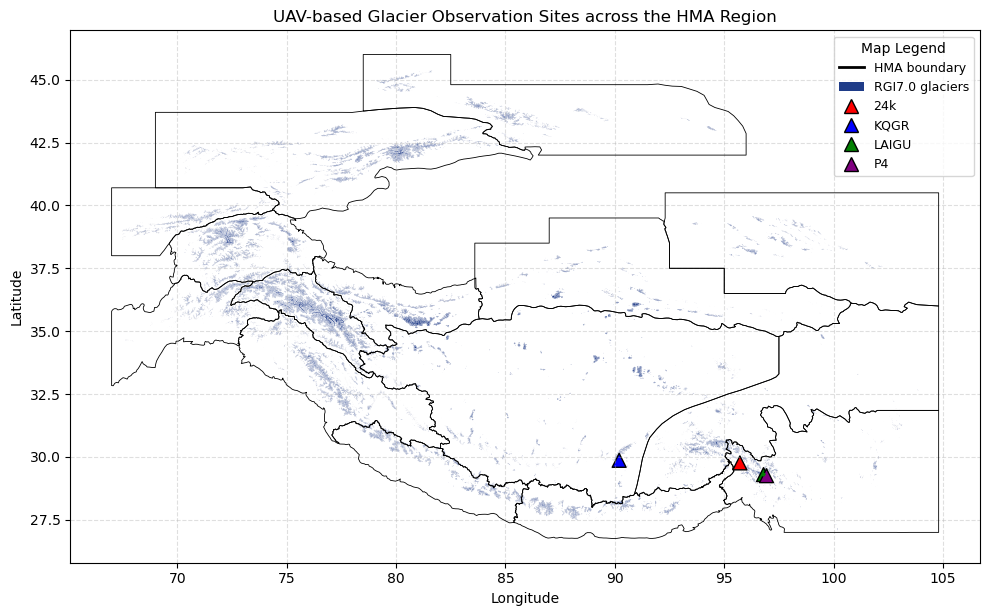

In [8]:
colors = {"24k":"red","KQGR":"blue","LAIGU":"green","P4":"purple"}
dsm_gdf["color"] = dsm_gdf["glacier"].map(colors)
dsm_display = dsm_gdf.drop_duplicates("glacier")  # 每个实测脚点只显示一个（实测日期不同但位置相同）
fig, ax = plt.subplots(figsize=(10,10))
hma.boundary.plot(ax=ax, edgecolor="black", linewidth=0.6)
rgi.plot(ax=ax, facecolor="#1f3b88", edgecolor="white", linewidth=0.05)
dsm_gdf.boundary.plot(ax=ax, edgecolor=dsm_gdf["color"], linewidth=2)
ax.scatter(dsm_display.geometry.centroid.x, dsm_display.geometry.centroid.y,  # 脚点三角图例，以边界几何质心绘制三角
           marker="^", s=100, edgecolor="black", c=dsm_display["color"])

handles = [
    Line2D([0],[0], color="black", lw=2, label="HMA boundary"),
    mpatches.Patch(facecolor="#1f3c88", label="RGI7.0 glaciers"),
] + [
    Line2D([0],[0], marker="^", markersize=10, linestyle="",
           markeredgecolor="black", markerfacecolor=row.color,
           label=row.glacier)
    for _, row in dsm_display.iterrows()
]

ax.legend(handles=handles, title="Map Legend", loc="upper right", fontsize=9)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.4)
ax.set_title("UAV-based Glacier Observation Sites across the HMA Region")

plt.tight_layout()
plt.show()
